## Necessary imports

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from functools import partial
import time

## Model definition (MNIST)
Declaration of a simple fully connected neural network (MLP) with 4 linear layers

In [5]:
class MNIST_model(torch.nn.Module):
	def __init__(self, d_in, K, d_out):
		""" Initialization of the MLP
			INPUT : 
				d_in= int (total number of features (i.e. pixels) of the images)
				K= int (hidden dimension of the layers in the NN)
				d_out= int (number of classes in the classification problem)
		"""
		super().__init__()
		self.input_layer = torch.nn.Linear(d_in, K)
		self.input_phi = torch.nn.ReLU()
		self.layer1 = torch.nn.Linear(K,K)
		self.phi1 = torch.nn.ReLU()
		self.layer2 = torch.nn.Linear(K,K)
		self.phi2 = torch.nn.ReLU()
		self.output_layer = torch.nn.Linear(K,d_out)

	def forward(self, Z):
		""" Forward pass of the network
			INPUT  : 
				Z= batch of n 28 by 28 pixels images (torch tensor of shape (n, 28, 28))
			OUTPUT : 
				f(Z)= torch tensor f(Z) (effect of the MLP on Z) of shape (n, d_out)
		"""
		Z = torch.flatten(Z, 1)
		Z = self.input_layer(Z)
		Z = self.input_phi(Z)
		Z = self.layer1(Z)
		Z = self.phi1(Z)
		Z = self.layer2(Z)
		Z = self.phi2(Z)
		Z = self.output_layer(Z)
		return Z
	
	def compute_proba(self, output) :
		return torch.nn.functional.softmax(output, dim= 1)

## Training Script

In [40]:
from torchvision import datasets, transforms

def train_epoch(model, device, train_loader, optimizer, epoch, criterion= torch.nn.functional.cross_entropy):
	model.train()  # Setting the model to train mode

	loss_history = []
	accuracy_history = []

	for batch_idx, (data, target) in enumerate(train_loader):
		data= data.to(device)
		target= target.to(device)
		output = model.forward(data)
		probas= model.compute_proba(output)

		loss = criterion(probas, target)

		loss.backward()

		optimizer.step()

		optimizer.zero_grad()

		pred = output.argmax(dim=1, keepdim=True)
		correct = pred.eq(target.view_as(pred)).sum().item()

		loss_history.append(loss.item())
		accuracy_history.append(correct / len(data))

		if batch_idx % (len(train_loader.dataset) // len(data) // 10) == 0:
			print(
				f"Train Epoch: {epoch}-{batch_idx} batch_loss={loss.item()/len(data):0.2e} batch_acc={correct/len(data):0.3f}"
			)

	return loss_history, accuracy_history


@torch.no_grad()
def validate(model, device, val_loader, criterion):
	model.eval()  # Setting model to evaluation mode
	test_loss = 0
	correct = 0
	for data, target in val_loader:
		data, target = data.to(device), target.to(device)
		output = model(data)
		test_loss += criterion(output, target).item() * len(data)
		pred = output.argmax(
			dim=1, keepdim=True
		)  # get the index of the max log-probability
		correct += pred.eq(target.view_as(pred)).sum().item()

	test_loss /= len(val_loader.dataset)

	print(
		"Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
			test_loss,
			correct,
			len(val_loader.dataset),
			100.0 * correct / len(val_loader.dataset),
		)
	)
	return test_loss, correct / len(val_loader.dataset)


@torch.no_grad()
def get_predictions(model, device, val_loader, criterion, num=None):
	model.eval()
	points = []
	for data, target in val_loader:
		data, target = data.to(device), target.to(device)
		output = model(data)
		loss = criterion(output, target)
		pred = output.argmax(dim=1, keepdim=True)

		data = np.split(data.cpu().numpy(), len(data))
		loss = np.split(loss.cpu().numpy(), len(data))
		pred = np.split(pred.cpu().numpy(), len(data))
		target = np.split(target.cpu().numpy(), len(data))
		points.extend(zip(data, loss, pred, target))

		if num is not None and len(points) > num:
			break
	return points


def run_mnist_training(num_epochs, lr, batch_size, device, optimization_algo):
	# ===== Data Loading =====
	# Input images are normalized
	transform = transforms.Compose(
		[transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
	)
	train_set = datasets.MNIST("./data", train=True, download=True, transform=transform)

	# Using the test set as a validation set
	val_set = datasets.MNIST("./data", train=False, transform=transform)

	train_loader = torch.utils.data.DataLoader(
		train_set,
		batch_size=batch_size,
		shuffle=True,  # Can be important for training
		pin_memory=torch.cuda.is_available(),
		drop_last=True,
		num_workers=2,
	)
	val_loader = torch.utils.data.DataLoader(
		val_set,
		batch_size=batch_size,
	)

	# Model, Optimizer and Criterion
	model = MNIST_model(d_in= 28*28, K= 128, d_out= 10)
	model = model.to(device=device)
	optimizer = optimization_algo(model.parameters(), lr=lr)
	criterion = torch.nn.functional.cross_entropy

	# Learning rate scheduler (decrease lr_new= factor*old_lr if no improvement in accuracy for 3 epoch in a row)
	scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode= 'max', patience= 3, factor= 0.5, verbose= True)


	# Train Model
	train_loss_history = []
	train_acc_history = []
	val_loss_history = []
	val_acc_history = []
	for epoch in range(1, num_epochs + 1):
		train_loss, train_acc = train_epoch(
			model, device, train_loader, optimizer, epoch, criterion
		)
		train_loss_history.extend(train_loss)
		train_acc_history.extend(train_acc)

		val_loss, val_acc = validate(model, device, val_loader, criterion)
		val_loss_history.append(val_loss)
		val_acc_history.append(val_acc)

		scheduler.step(val_acc)

	# ===== Plot training curves =====
	n_train = len(train_acc_history)
	t_train = num_epochs * np.arange(n_train) / n_train
	t_val = np.arange(1, num_epochs + 1)
	plt.figure()
	plt.plot(t_train, train_acc_history, label="Train")
	plt.plot(t_val, val_acc_history, label="Val")
	plt.legend()
	plt.xlabel("Epoch")
	plt.ylabel("Accuracy")

	plt.figure()
	plt.plot(t_train, train_loss_history, label="Train")
	plt.plot(t_val, val_loss_history, label="Val")
	plt.legend()
	plt.xlabel("Epoch")
	plt.ylabel("Loss")

	# ===== Plot low/high loss predictions on validation set =====
	points = get_predictions(
		model,
		device,
		val_loader,
		partial(torch.nn.functional.cross_entropy, reduction="none"),
	)
	points.sort(key=lambda x: x[1])
	plt.figure(figsize=(15, 6))
	for k in range(5):
		plt.subplot(2, 5, k + 1)
		plt.imshow(points[k][0].reshape(28, 28), cmap="gray")
		plt.title(f"true={int(points[k][3])} pred={int(points[k][2])}")
		plt.subplot(2, 5, 5 + k + 1)
		plt.imshow(points[-k - 1][0].reshape(28, 28), cmap="gray")
		plt.title(f"true={int(points[-k-1][3])} pred={int(points[-k-1][2])}")

## Training the model

c:\Users\vince\anaconda3\envs\MLenv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1-0 batch_loss=3.84e-02 batch_acc=0.100
Train Epoch: 1-100 batch_loss=2.83e-02 batch_acc=0.767
Train Epoch: 1-200 batch_loss=2.73e-02 batch_acc=0.850
Train Epoch: 1-300 batch_loss=2.58e-02 batch_acc=0.917
Train Epoch: 1-400 batch_loss=2.60e-02 batch_acc=0.900
Train Epoch: 1-500 batch_loss=2.59e-02 batch_acc=0.900
Train Epoch: 1-600 batch_loss=2.46e-02 batch_acc=1.000
Train Epoch: 1-700 batch_loss=2.62e-02 batch_acc=0.900
Train Epoch: 1-800 batch_loss=2.55e-02 batch_acc=0.933
Train Epoch: 1-900 batch_loss=2.59e-02 batch_acc=0.900
Test set: Average loss: 0.4274, Accuracy: 9378/10000 (94%)
Train Epoch: 2-0 batch_loss=2.51e-02 batch_acc=0.950
Train Epoch: 2-100 batch_loss=2.49e-02 batch_acc=0.967
Train Epoch: 2-200 batch_loss=2.53e-02 batch_acc=0.950
Train Epoch: 2-300 batch_loss=2.50e-02 batch_acc=0.967
Train Epoch: 2-400 batch_loss=2.58e-02 batch_acc=0.917
Train Epoch: 2-500 batch_loss=2.49e-02 batch_acc=0.967
Train Epoch: 2-600 batch_loss=2.50e-02 batch_acc=0.950
Train Epoc

C:\Users\vince\AppData\Local\Temp\ipykernel_29556\2669595706.py:167: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"true={int(points[k][3])} pred={int(points[k][2])}")
C:\Users\vince\AppData\Local\Temp\ipykernel_29556\2669595706.py:170: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"true={int(points[-k-1][3])} pred={int(points[-k-1][2])}")


Total Training Time :  258.63226590002887  s


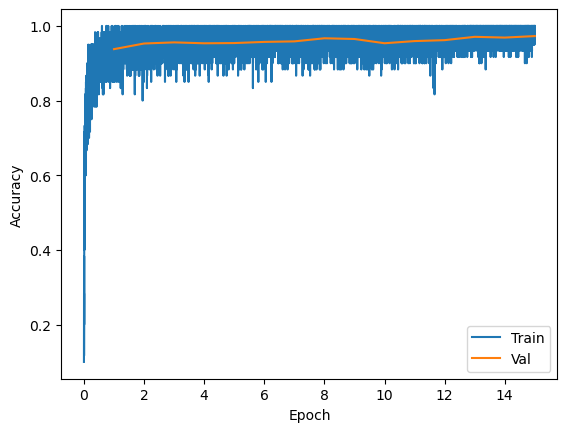

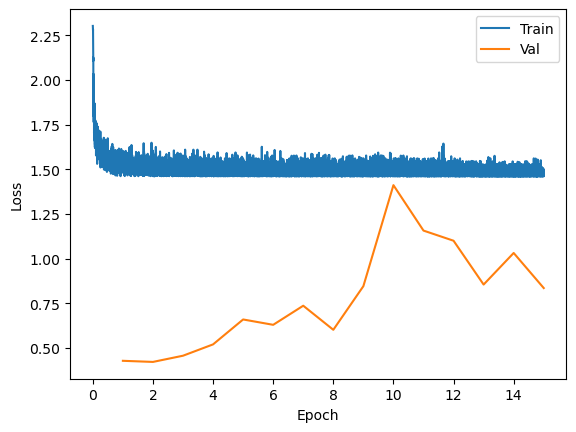

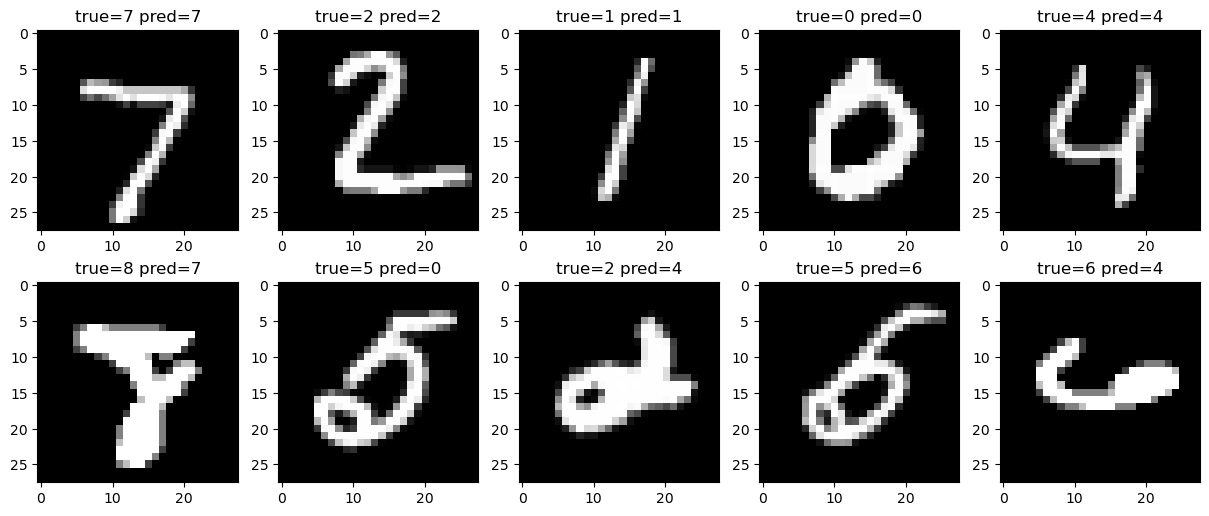

In [41]:
# The train set has a total of 60000 images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimization_algo= torch.optim.Adam
if optimization_algo == torch.optim.SGD :
	lr = 1e-1
	batch_size = 60 # The train set has 60000 images
	num_epochs = 15
else : # if Adam
	lr = 1e-3
	batch_size = 60 # The train set has 60000 images
	num_epochs = 15

t1= time.perf_counter()
run_mnist_training(num_epochs, lr, batch_size, device, optimization_algo)
print("Total Training Time : ", time.perf_counter() - t1, " s")

# Results (8 epochs)
Best results for SGD :
- batch_size= 60
- lr= 1e-1
- Test set accuracy : 96 %
- total time= 110.5 s

Best results for Adam :
- batch_size= 600
- lr= 1e-3
- test set accuracy : 9672/10000 (97%)
- total time= 104 s